Trial 30 Complete [00h 00m 21s]
val_loss: 0.030425438657402992

Best val_loss So Far: 0.0002675571304280311
Total elapsed time: 00h 06m 53s

🎯 En iyi hiperparametreler:
units_1: 128
units_2: 128
dropout_1: 0.2
dropout_2: 0.4
optimizer: adam
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 


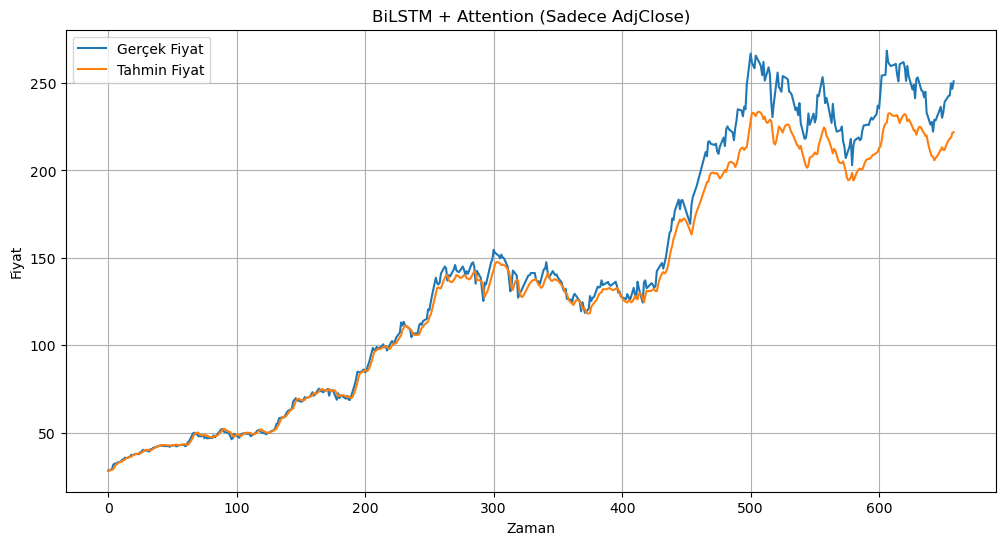

✅ Test RMSE: 13.422414028630907
📉 Test MAPE: 4.63%


In [7]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Layer
from kerastuner.tuners import Hyperband
import tensorflow.keras.backend as K
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %% Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal')
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# %% Veri yükleme ve hazırlık
data = pd.read_csv('Merged_Data.csv', parse_dates=['Tarih'], index_col='Tarih', sep=',', decimal='.', date_format='%Y-%m-%d')
data = data.drop(columns=["Hacim", "Fark%", "GDP"], errors='ignore')
data.dropna(inplace=True)

# Sadece AdjClose
feature_cols = ['AdjClose']
target_col = 'AdjClose'

X_all = data[feature_cols].values
y_all = data[[target_col]].values

# Ölçekleme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)

# Sekans oluştur
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 4
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Eğitim/test böl
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# %% Attention'lı model fonksiyonu
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_1', 32, 128, step=32),
        return_sequences=True
    ), input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
    model.add(Bidirectional(LSTM(
        units=hp.Int('units_2', 32, 128, step=32),
        return_sequences=True
    )))
    
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Attention())
    model.add(Dense(1))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    
    return model

# %% Tuner başlat
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_logs',
    project_name='bilstm_attention_adjclose'
)

# %% Tuner eğitimi
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             verbose=1)

# %% En iyi modeli al ve eğit
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n🎯 En iyi hiperparametreler:")
for param in ['units_1', 'units_2', 'dropout_1', 'dropout_2', 'optimizer']:
    print(f"{param}: {best_hps.get(param)}")

history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)

# %% Tahmin ve görselleştirme
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek Fiyat')
plt.plot(y_pred, label='Tahmin Fiyat')
plt.title('BiLSTM + Attention (Sadece AdjClose)')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True)
plt.show()

# %% RMSE & MAPE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
print("✅ Test RMSE:", rmse)
print("📉 Test MAPE: %.2f%%" % mape)


In [8]:
import copy
from sklearn.metrics import mean_squared_error

baseline_pred = best_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

feature_importances = []

for i in range(X_test.shape[2]):  # özellik sayısı kadar dön
    X_test_copy = copy.deepcopy(X_test)
    np.random.shuffle(X_test_copy[:, :, i])  # sadece i. özelliği karıştır
    shuffled_pred = best_model.predict(X_test_copy)
    shuffled_rmse = np.sqrt(mean_squared_error(y_test, shuffled_pred))
    importance = shuffled_rmse - baseline_rmse
    feature_importances.append((feature_cols[i], importance))

# Önem sırasına göre yazdır
feature_importances.sort(key=lambda x: x[1], reverse=True)
print("\n📊 Özellik Önem Sıralaması (Permutation Importance):")
for feat, imp in feature_importances:
    print(f"{feat}: Önem Skoru = {imp:.6f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

📊 Özellik Önem Sıralaması (Permutation Importance):
AdjClose: Önem Skoru = 0.318278
